# Object recognition using googlenet V2 on Intel Compute Stick.
## Codes works on both Neural Compute Stick 2 and Movidius compute Stick-1

# Imports: Note source need to be initialized according to the installed folder of the OpenVINO

In [12]:
# # Ensure that the OpenVINO environment is initialized
# source /opt/intel/computer_vision_sdk/bin/setupvars.sh

import sys
import os
import logging as log
import cv2
import numpy as np
from time import time
from openvino.inference_engine import IENetwork, IEPlugin

# Points to the downloaded and optimized model.
## Do the setup first

In [13]:
model_xml = '/opt/intel/computer_vision_sdk/deployment_tools/model_downloader/classification/googlenet/v2/caffe/googlenet-v2.xml'
model_bin = '/opt/intel/computer_vision_sdk/deployment_tools/model_downloader/classification/googlenet/v2/caffe/googlenet-v2.bin'

# Device type is: MYRIAD

In [14]:
plugin = IEPlugin(device='MYRIAD', plugin_dirs=None)

# Net and input, ouput blobs

In [15]:
net = IENetwork.from_ir(model=model_xml, weights=model_bin)

input_blob = next(iter(net.inputs))
out_blob = next(iter(net.outputs))

# Only one image as input
net.batch_size =1

# Resizing the image based on network input layer

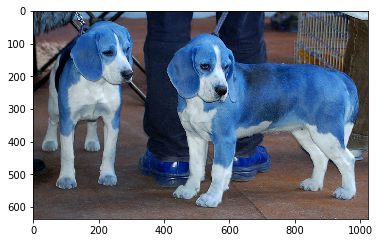

Image is resized from (636, 1024) to (224, 224)
Batch size is 1


In [16]:
# Read and pre-process input images
n, c, h, w = net.inputs[input_blob].shape
images = np.ndarray(shape=(n, c, h, w))

image = cv2.imread('data/image1.jpg')

from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()

if image.shape[:-1] != (h, w):
    print("Image is resized from {} to {}".format(image.shape[:-1], (h, w)))
    image = cv2.resize(image, (w, h))
image = image.transpose((2, 0, 1))  # Change data layout from HWC to CHW
images[0] = image
print("Batch size is {}".format(n))

# Putting the model on the device Running the inference

In [17]:
t0 = time()

# Loading model to the plugin
print("Loading model to the plugin")
exec_net = plugin.load(network=net)

res = exec_net.infer(inputs={input_blob: images})
t1 = time()

print('Total Time taken transfer model and to run Inference is:', t1-t0)

del net

Loading model to the plugin
Total Time taken transfer model and to run Inference is: 3.8524413108825684


In [18]:
t0 = time()
res = exec_net.infer(inputs={input_blob: images})
t1 = time()

print('Time to run Inference is:', t1-t0)

Time to run Inference is: 0.14401817321777344


# Using labels

In [19]:
labels_map = []

f=open('data/' + 'googlenetv2.labels', 'r')
labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]

# Processing the results

In [20]:
# Processing output blob
print("Processing output blob")
res = res[out_blob]
top_number = 5

#labels_map =None

for i, probs in enumerate(res):
    probs = np.squeeze(probs)
    top_ind = np.argsort(probs)[-top_number:][::-1]

    for id in top_ind:
        det_label = labels_map[id]  if labels_map else "#{}".format(id)
        print("{:.7f} label {}".format(probs[id], det_label))
    print("\n")

Processing output blob
0.9150391 label blue heron, Egretta caerulea
0.0549011 label hound, Afghan
0.0138016 label retriever
0.0058060 label frog, tree-frog
0.0032597 label jay




# Cleanup

In [21]:
del exec_net
del plugin